# Analysis: Visualizing Model Training <a class="tocSkip">

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Imports-&amp;-Config" data-toc-modified-id="Imports-&amp;-Config-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Imports &amp; Config</a></span></li><li><span><a href="#Visualize-Training" data-toc-modified-id="Visualize-Training-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Visualize Training</a></span></li></ul></li><li><span><a href="#GGNN-(A)---Layer-Ablation" data-toc-modified-id="GGNN-(A)---Layer-Ablation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>GGNN (A) - Layer Ablation</a></span></li><li><span><a href="#GGNN-(B)---run_over_binary_choices" data-toc-modified-id="GGNN-(B)---run_over_binary_choices-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>GGNN (B) - run_over_binary_choices</a></span></li><li><span><a href="#GGNN-(C)---run_with_node_types_and_structure_only" data-toc-modified-id="GGNN-(C)---run_with_node_types_and_structure_only-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>GGNN (C) - run_with_node_types_and_structure_only</a></span></li><li><span><a href="#Monitoring-Debug-Trash-Folder" data-toc-modified-id="Monitoring-Debug-Trash-Folder-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Monitoring Debug Trash Folder</a></span></li></ul></div>

## Imports \& Config

In [1]:
# Set editor width to something sane
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import sys
# get root repository path
a = !pwd
repo_root = a[0].rsplit('ProGraML', maxsplit=1,)[0] + 'ProGraML'
print(repo_root)
#insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, repo_root)
repo_root = Path(repo_root)

import pandas as pd
from itertools import cycle

import pickle, json
from matplotlib import pyplot as plt
import numpy as np
import tqdm
import torch
from torch_geometric.data import Data, DataLoader

/home/zacharias/ProGraML


## Visualize Training

In [20]:
def get_all_runs(log_dir, subfolders=False, exclude=['test_only'], upper_bound_epochs=None):
    print(log_dir.name)
    assert subfolders == False, 'not implemented'
    logs = {}
    hyps = {}
    for file in log_dir.glob('*_log.json'):
        with open(file, 'r') as f:
            run_name = file.name.rsplit('_log.json')[0]
            # load hyps
            hyp_file = file.parent / (run_name + '_params.json')
            try:
                with open(hyp_file, 'r') as h:
                    hyp = json.load(h)
            except FileNotFoundError:
                hyp = ''
            
            hyps[run_name] = hyp
            
            # skip weird files
            if run_name[:2] == '._':
                continue

            print(run_name)
            
            log = pd.read_json(f, orient='records')
            
            # handle 'test_only' epochs later!
            if log['epoch'].values[0] == 'test_only':
                continue
            
            # flatten dataframe
            try:
                valid = pd.DataFrame(log.valid_results.tolist(), columns=['valid_loss', 'valid_acc', 'valid_speed'])
                train = pd.DataFrame(log.train_results.tolist(), columns=['train_loss', 'train_acc', 'train_speed'])
            except AssertionError:
                valid = pd.DataFrame(log.valid_results.tolist(), columns=['valid_loss', 'valid_acc', 'valid_speed', 'valid_ppl'])
                train = pd.DataFrame(log.train_results.tolist(), columns=['train_loss', 'train_acc', 'train_speed', 'test_ppl'])
            if hasattr(log, 'test_results'):
                try:
                    test = pd.DataFrame(log.test_results.tolist(), columns=['test_loss', 'test_acc', 'test_speed'])
                except AssertionError:
                    test = pd.DataFrame(log.test_results.tolist(), columns=['test_loss', 'test_acc', 'test_speed', 'test_ppl'])
                    
                df = pd.concat([log.epoch, log.time, train, valid, test], axis=1)
            else:
                df = pd.concat([log.epoch, log.time, train, valid], axis=1)
                
            if upper_bound_epochs is not None:
                df = df[df['epoch'] <= upper_bound_epochs]
                
            logs[run_name] = df
    return logs, hyps

In [25]:
def make_label(name, split, hyps, display_list=None):
    shorthands = {'lr': "lr{hyp[lr]:.5f}",
                  'batch_size': "bs{hyp[batch_size]:3d}",
                  'train_subset':"ts{hyp[train_subset][1]:3d}",
                  'graph_state_dropout': "gsd{hyp[graph_state_dropout]:.1f}",
                  'output_dropout': "od{hyp[output_dropout]:.1f}",
                  'edge_weight_dropout': "ewd{hyp[edge_weight_dropout]:.1f}",
                  'position_embeddings': "pos{hyp[position_embeddings]:1d}",
                  'use_node_types': "ntyp{hyp[use_node_types]:1d}",
                  'use_edge_bias': "ebias{hyp[use_edge_bias]:1d}",
                  'msg_mean_aggregation': "mean{hyp[msg_mean_aggregation]:1d}",
                  'inst2vec_embeddings': "i2v:{hyp[inst2vec_embeddings][0]}",
                  'attn_bias': "attn_b:{hyp[attn_bias]:1d}",
                  'attn_num_heads': "attn_h:{hyp[attn_num_heads]:1d}",
                  'attn_dropout': "attn_d:{hyp[attn_dropout]:.1f}",
                  'tfmr_act': "tfmr_act:{hyp[tfmr_act]}",
                  'tfmr_dropout': "tfmr_d:{hyp[tfmr_dropout]}",
                  'tfmr_ff_sz': "tfmr_ff:{hyp[tfmr_ff_sz]}",
                  'layer_timesteps': "lt{hyp[layer_timesteps]}",

                 }
    
    hyp = hyps[name]
    
    # set to display all _available_ hyperparams if display_list is none
    if display_list is None:
        display_list = [x for x in list(hyp.keys()) if x in shorthands]
    for k in display_list:
        if k not in hyp:
            hyp[k] = None
    #print(display_list)
    hyp_str = ' '.join([shorthands[x].format(hyp=hyp) for x in display_list])

    return hyp_str + '\n' + name

In [53]:
def annot_max(x,y, test_y, color='k', label=None, ax=None, invert_acc=True):
    xargmax = x[np.argmax(np.array(y))]
    xmax = x.max()
    ymax = y.max()
    test_y = test_y[np.argmax(np.array(y))]
    
    if invert_acc:  # display error % instead
        text= "val err {:.2f}%, test err {:.2f}% @ ep {:d}/{:d}".format((1-ymax)*100, (1-test_y)*100, int(xargmax), int(xmax))
    else:
        text= "val acc {:.4f}, test acc {:.4f} @ ep {:d}/{:d}".format(ymax, test_y, int(xargmax), int(xmax))
    if label:
        text = text + '\n' + label
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3",
                      fc='w',
                      ec=color,
                      lw=0.72)
    arrowprops = dict(arrowstyle="->",
                    #connectionstyle="angle,angleA=0,angleB=60",
                    color=color)
    kw = dict(xycoords='data',
              textcoords='data',
              #textcoords="axes fraction",
              arrowprops=arrowprops,
              bbox=bbox_props,
              ha="right",
              va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax + np.random.uniform(-xmax/1.5,xmax/2) , max((ymax - 0.951)*24 + 0.7, 0.91 + np.random.uniform(-0.01, 0.01))) , **kw)  # xytext=(xmax,0.90 + (np.random.rand() - 0.5) / 5)

In [34]:
def plot_logs(logs, hyps, lower_ylim=0.85, display_list=None, legend_loc='lower left'):
    plt.figure(figsize=(24, 12))
    #cycle_colors=iter(plt.cm.hsv(np.linspace(0,0.97,len(logs)))) #jet / hsv / rainbow
    cycle_colors = cycle(iter(plt.rcParams['axes.prop_cycle'].by_key()['color']))
    for name, log in logs.items():
        if log['valid_acc'].max() < 0.96:
            #continue
            pass
        c = next(cycle_colors) #next(color)

        plt.plot(log['epoch'], log['valid_acc'], label='_nolegend_', ls='dashed', c=c) # , label=make_label(name, 'valid')
        plt.plot(log['epoch'], log['train_acc'], label='_nolegend_', ls='dotted', c=c) # make_label(name, 'train')
        if hasattr(log, 'test_acc'):
            label = make_label(name, 'test', hyps, display_list=display_list)
            plt.plot(log['epoch'], log['test_acc'], label=label.replace('\n', '  '), c=c)
            annot_max(log['epoch'], log['valid_acc'], log['test_acc'], c, label=label)

    #plt.minorticks_on()
    plt.yticks(np.arange(0, 1, step=0.05))
    plt.ylim((lower_ylim, 1.0))
    plt.grid(which='major', axis='x', c='grey')
    plt.grid(which='minor', axis='y', c='silver', ls='--')
    plt.grid(which='major', axis='y', c='black')
    plt.minorticks_on()
    plt.legend(loc=legend_loc, prop={'family': 'monospace'})

    plt.show()

# GGNN (A) - Layer Ablation

run_over_layer_timesteps
2020-01-23_04:44:49_poj003_24508
2020-01-23_04:42:19_poj002_24507
2020-01-23_05:33:53_poj004_24509
2020-01-23_04:41:44_poj001_24506
2020-01-23_04:40:57_poj000_24505


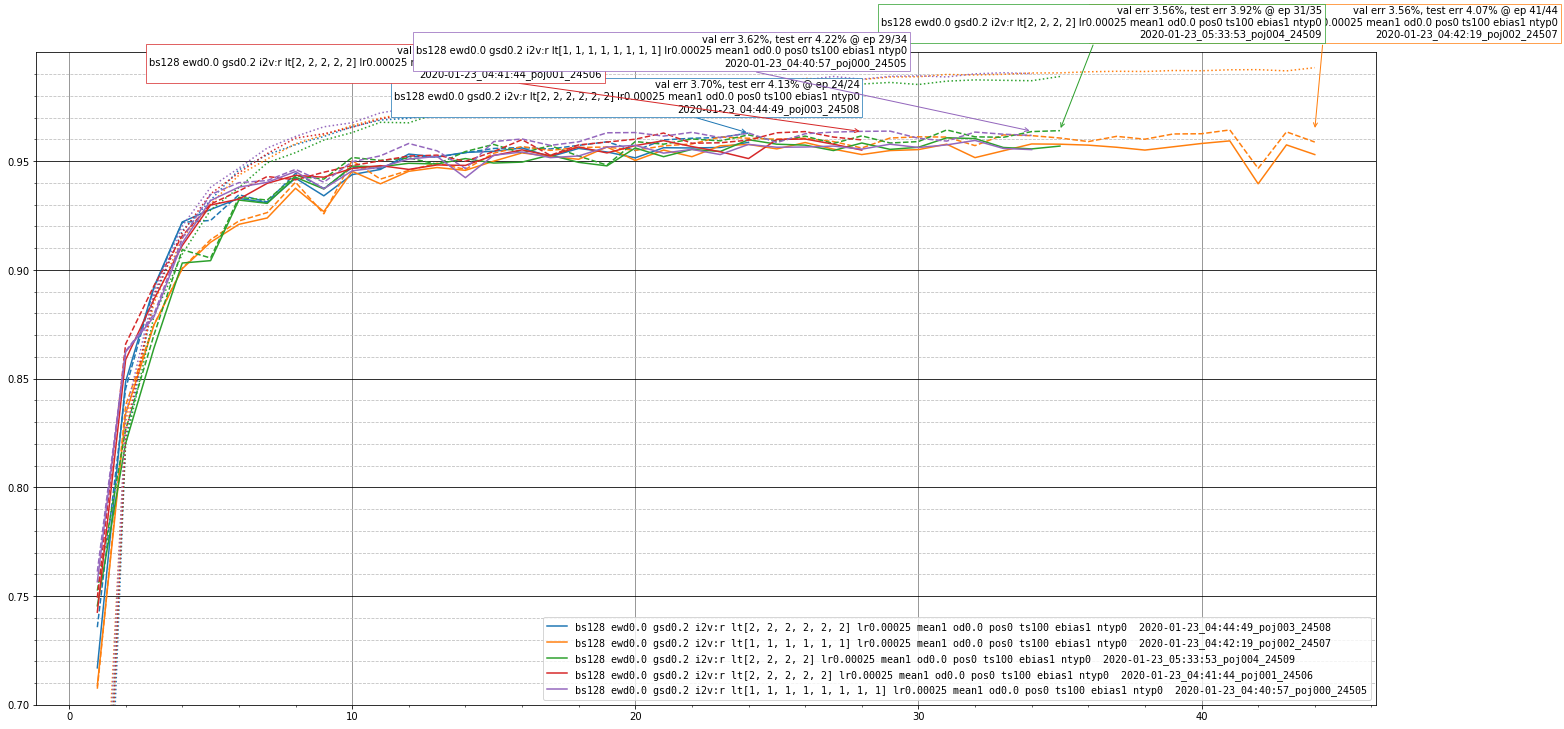

In [62]:
# set log_dir
#sub = 'ault_logs_mirror/example_subfolder'
#sub = 'ault_logs_mirror/sub10_ts4x2_bs64'
#sub = 'ault_logs_mirror/basic_run_full_subset_01-21_weird_testset/'
#sub = 'ault_logs_mirror/large_run_full_subset/'
#sub = 'ault_logs_mirror/run_over_binary_choices/'
sub = 'ault_logs_mirror/run_over_layer_timesteps/'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls -a {log_dir} | grep log
logs, hyps = get_all_runs(log_dir, upper_bound_epochs=60)
plot_logs(logs, hyps, lower_ylim=0.7, display_list=None, legend_loc='lower right')

# GGNN (B) - run_over_binary_choices

run_over_binary_choices
2020-01-23_01:36:53_poj009_24498
2020-01-23_04:38:45_poj013_24502
2020-01-23_01:33:36_poj000_24489
2020-01-23_04:35:01_poj012_24501
2020-01-23_01:35:34_poj001_24490
2020-01-23_01:35:52_poj004_24493
2020-01-23_01:36:53_poj008_24497
2020-01-23_01:35:52_poj005_24494


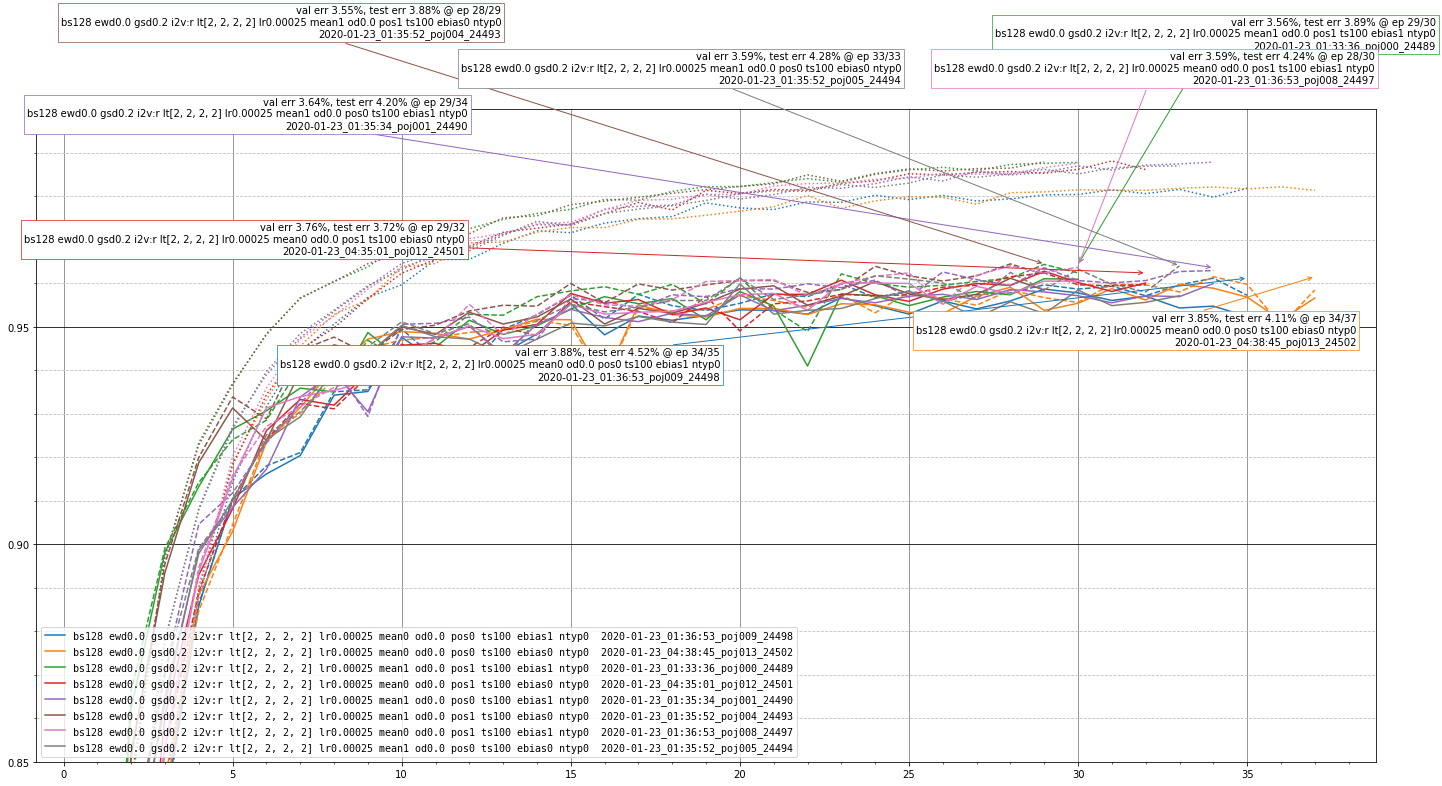

In [59]:
# set log_dir
#sub = 'ault_logs_mirror/example_subfolder'
#sub = 'ault_logs_mirror/sub10_ts4x2_bs64'
#sub = 'ault_logs_mirror/basic_run_full_subset_01-21_weird_testset/'
#sub = 'ault_logs_mirror/large_run_full_subset/'
sub = 'ault_logs_mirror/run_over_binary_choices/'
#sub = 'ault_logs_mirror/run_over_layer_timesteps/'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls -a {log_dir} | grep log
logs, hyps = get_all_runs(log_dir)
plot_logs(logs, hyps)

# GGNN (C) - run_with_node_types_and_structure_only

run_with_node_types_and_structure_only
2020-01-23_23:00:54_nty002_24539
2020-01-23_18:25:55_nty001_24533
2020-01-23_20:56:11_nty000_24530
2020-01-24_01:18:36_nty002_24540
2020-01-23_20:43:33_nty003_24542
2020-01-23_18:24:34_nty000_24529
2020-01-23_20:57:43_nty001_24534
2020-01-23_20:43:30_nty002_24538
2020-01-23_23:28:05_nty000_24531
2020-01-24_01:17:52_nty003_24544
2020-01-23_23:29:51_nty001_24535
2020-01-24_02:00:13_nty000_24532
2020-01-24_02:01:47_nty001_24536
2020-01-23_18:25:59_nty002_24537
2020-01-23_18:25:59_nty003_24541
2020-01-23_23:00:52_nty003_24543


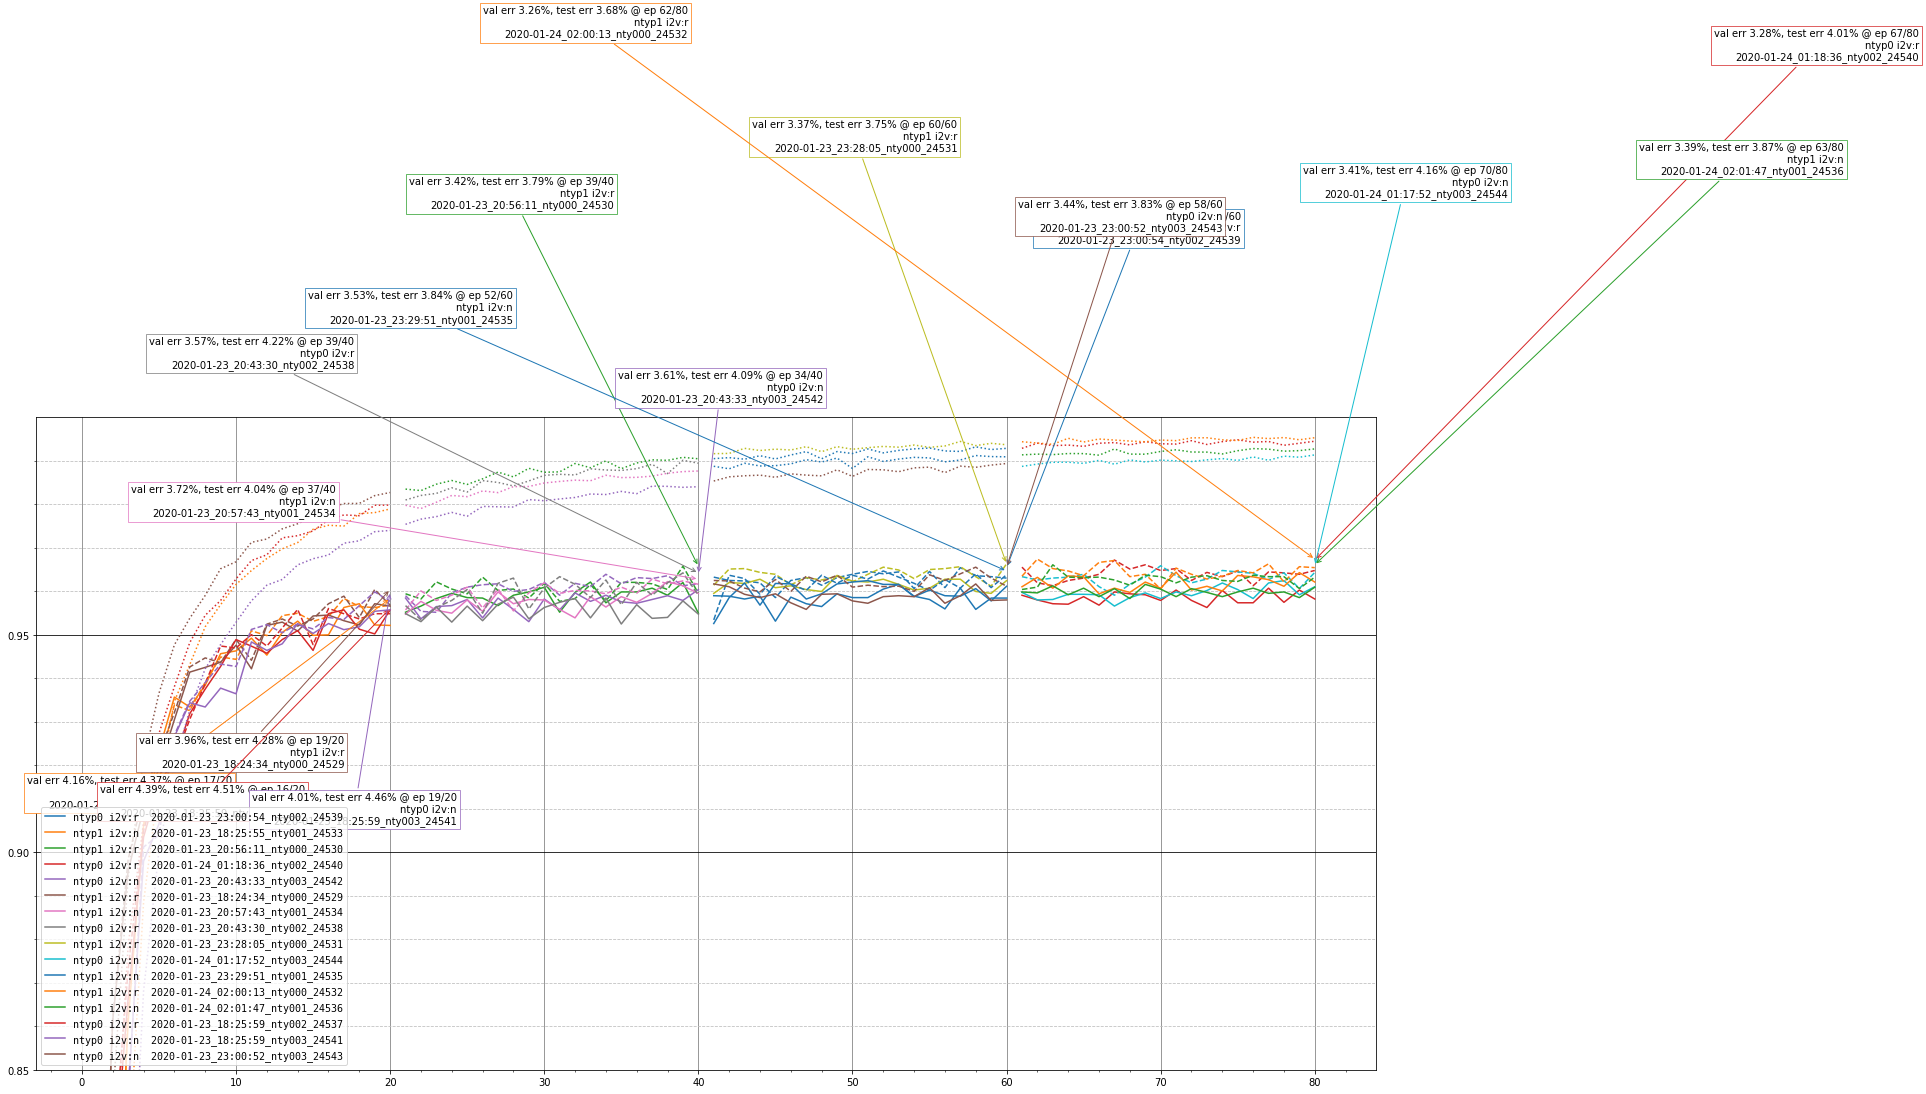

In [60]:
# set log_dir

sub = 'ault_logs_mirror/run_with_node_types_and_structure_only/'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls {log_dir.parent}
logs, hyps = get_all_runs(log_dir)
display_list = ['use_node_types', 'inst2vec_embeddings']
plot_logs(logs, hyps, lower_ylim=0.85, display_list=display_list)

# Monitoring Debug Trash Folder

debug_trash_folder
2020-02-01_13:39:22_627
2020-02-01_18:05:48_9456
2020-02-01_15:14:41_7845
2020-02-06_21:33:56_17926
2020-01-30_22:20:26_29586
2020-02-07_17:31:49_19736
2020-01-26_18:15:41_15148
2020-01-30_11:15:34_1552
2020-01-30_02:45:05_18067
2020-02-01_17:54:42_31051
2020-01-26_17:45:38_18228
2020-02-01_18:07:46_9456
2020-01-30_01:56:54_30012
2020-01-30_15:16:28_29123
2020-01-26_17:53:49_9840
2020-02-01_18:07:00_9456
2020-01-30_02:50:47_31824
2020-02-01_17:49:47_31051
2020-01-26_18:41:37_21849
2020-02-01_18:01:58_31051
2020-01-26_13:54:09_3105
2020-02-01_13:41:53_6971
2020-01-30_01:59:27_3920
2020-01-30_01:50:29_13380
2020-01-30_02:56:14_12722
2020-01-30_03:04:03_31510


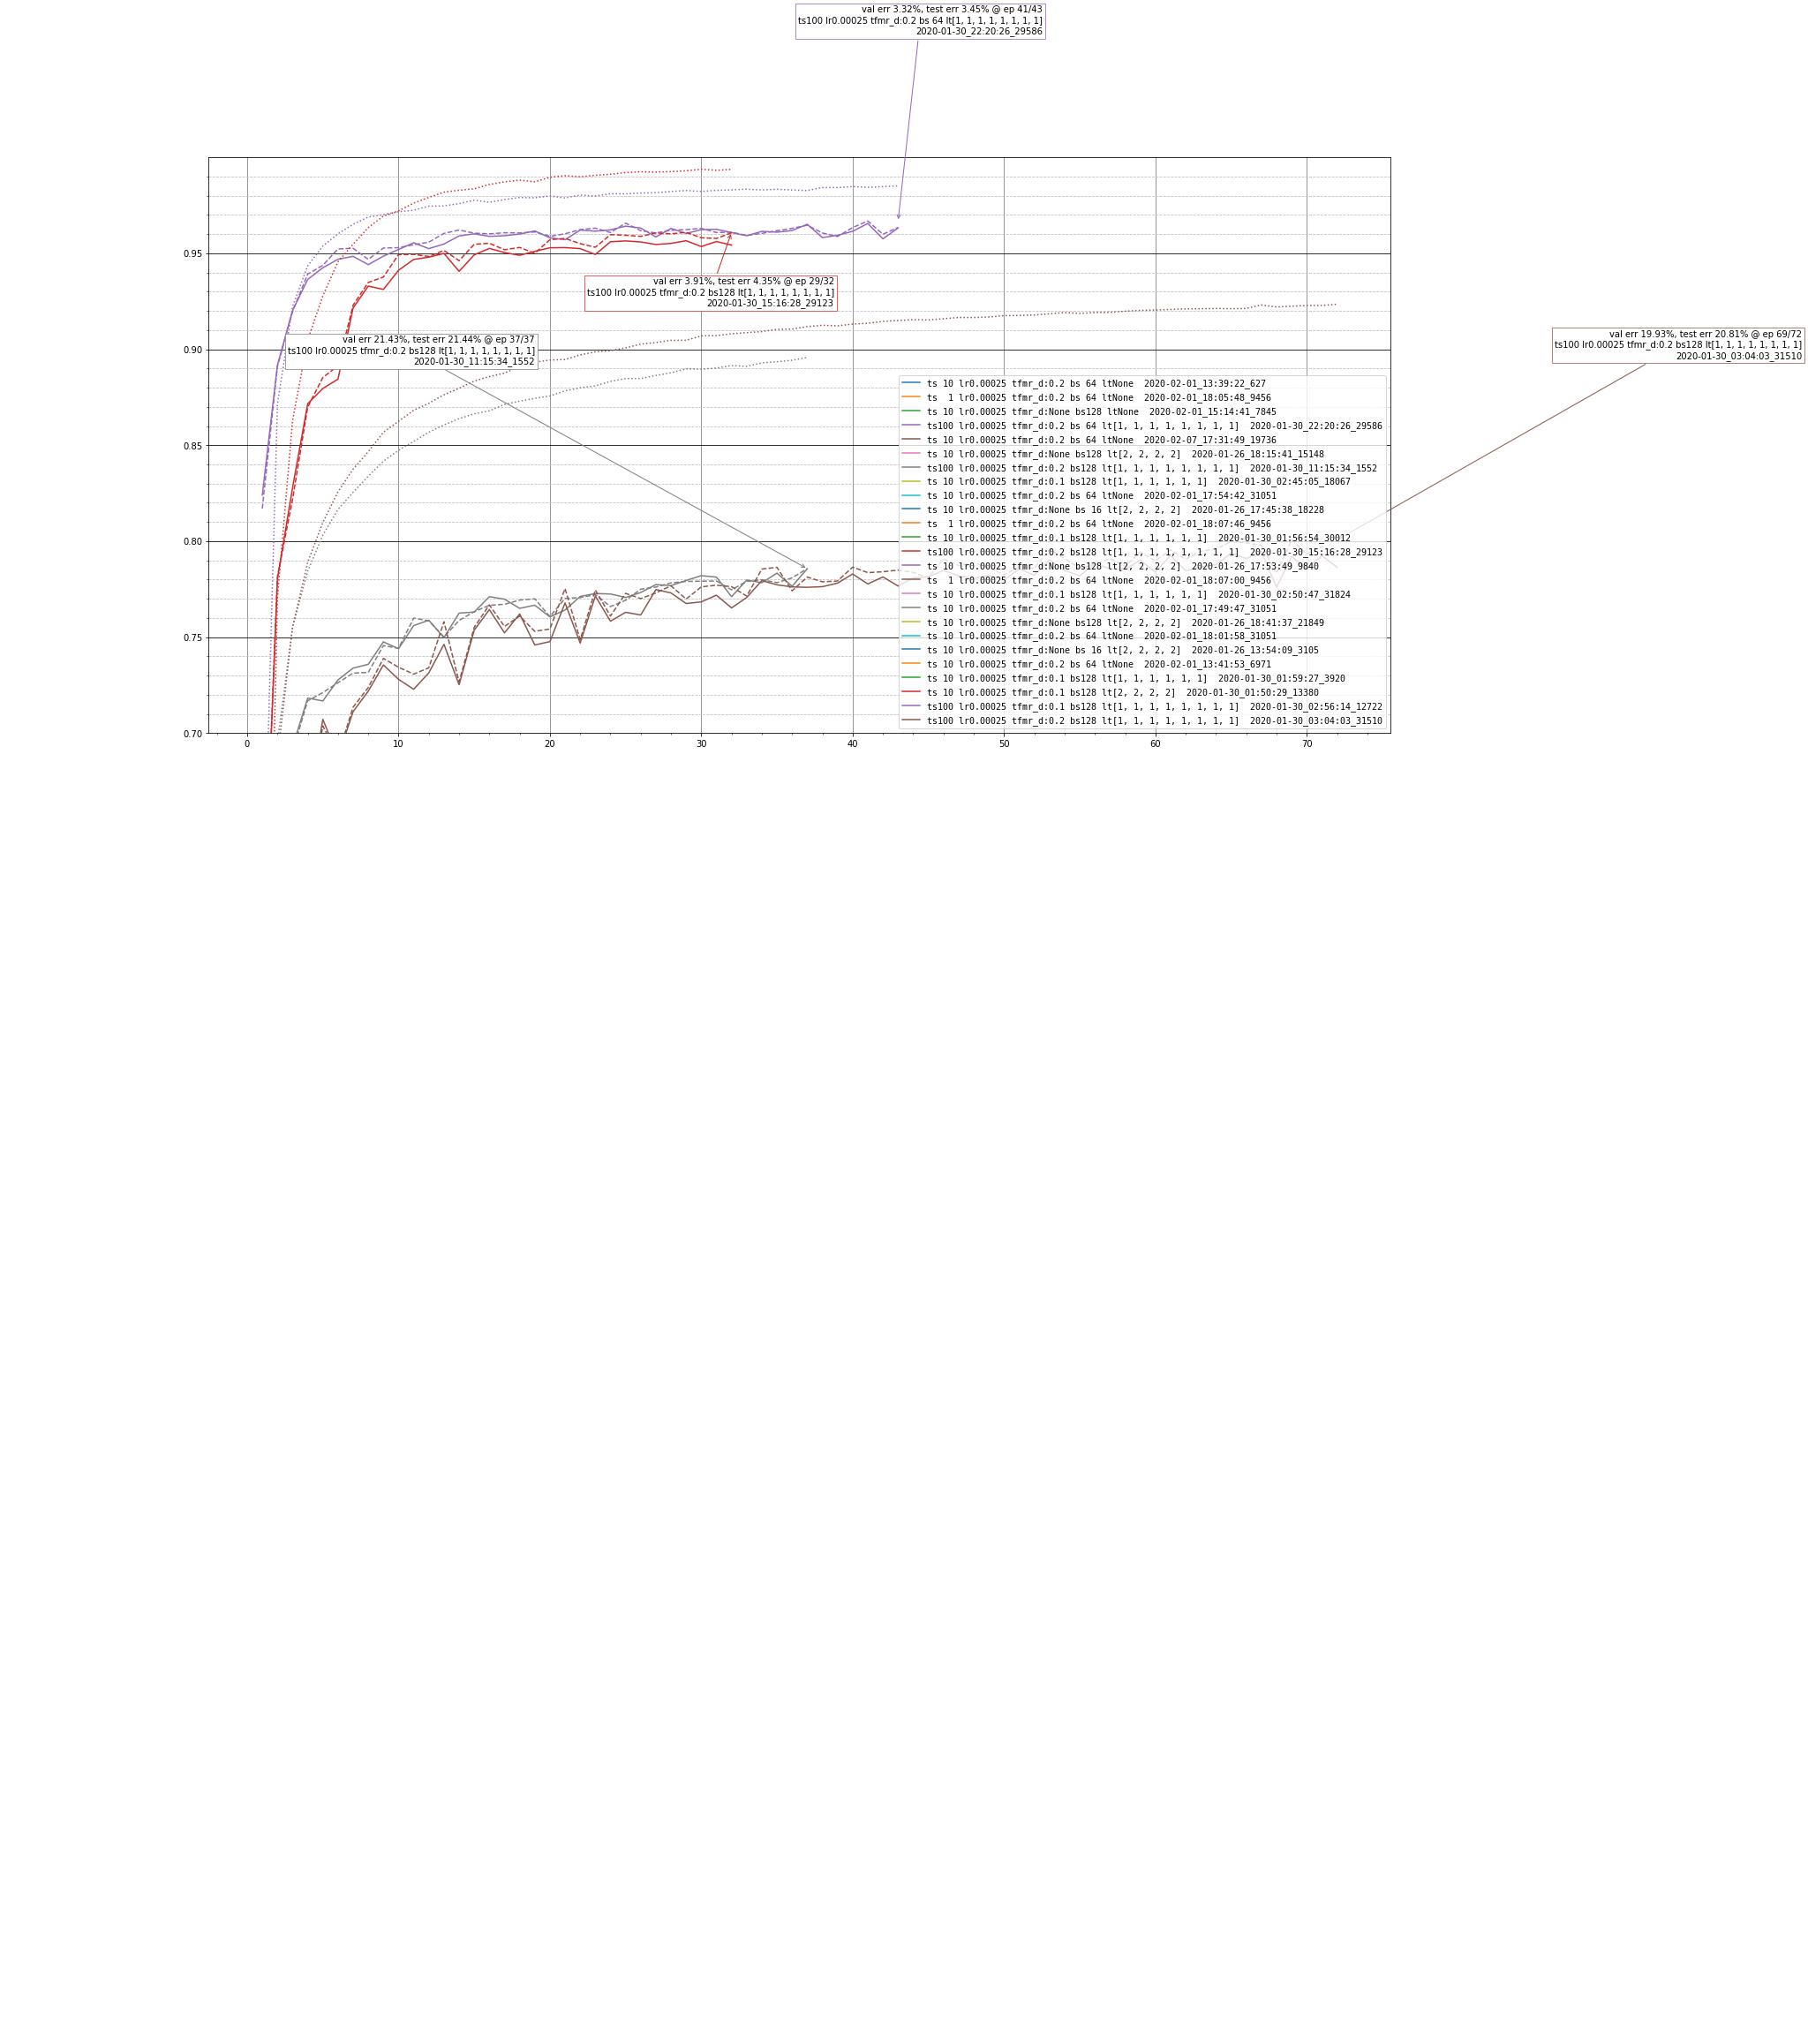

In [61]:
# set log_dir to debug runs 

sub = 'debug_trash_folder'
log_dir = repo_root / 'deeplearning/ml4pl/poj104/classifyapp_logs' / sub
#!ls {log_dir.parent}
logs, hyps = get_all_runs(log_dir)

display_list = ['train_subset', 'lr', 'tfmr_dropout', 'batch_size', 'layer_timesteps']

plot_logs(logs, hyps, lower_ylim=0.7, display_list=display_list, legend_loc='lower right')